## IMDB Sentiment Classification

In [1]:
from fastai.text import *
import html 

In [2]:
BOS='xbos' ##Beginning of sentence token
FLD='xfld' ## data field tag

In [3]:
PATH=Path('data/imdb/aclImdb')

#### Standardise Format

In [4]:
CLAS_PATH=Path('data/imdb/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True,parents=True)

LM_PATH=Path('data/imdb/imdb_lm/')
LM_PATH.mkdir(exist_ok=True,parents=True)

In [6]:
CLASSES=['neg','pos','unsup']

In [6]:
print(list(enumerate(CLASSES)))

[(0, 'neg'), (1, 'pos'), (2, 'unsup')]


In [8]:
def get_texts(path):
    texts,labels=[],[]
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts),np.array(labels)

In [9]:
trn_texts,trn_labels=get_texts(PATH/'train')
val_texts,val_labels=get_texts(PATH/'test')

In [10]:
len(trn_texts),len(val_texts)

(75000, 25000)

In [11]:
col_names=['labels','text']

In [12]:
np.random.seed(42)

trn_idx=np.random.permutation(len(trn_texts))
val_idx=np.random.permutation(len(val_texts))

In [15]:
trn_texts=trn_texts[trn_idx]
val_texts=val_texts[val_idx]

trn_labels=trn_labels[trn_idx]
val_labels=val_labels[val_idx]

In [16]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)

In [ ]:
df_trn.head

In [18]:
df_trn[df_trn['labels']!=2].to_csv(CLAS_PATH/'train.csv',header=False,index=False)

df_val.to_csv(CLAS_PATH/'test.csv',header=False,index=False)

(CLAS_PATH/'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

#### Now we create a language model first to learn the structure of english language and then use that model for sentiment classification. We use full 100k records for this purpose. LM doesn't require labels ,hence we ignore them

In [21]:
trn_texts,val_texts=sklearn.model_selection.train_test_split(np.concatenate([trn_texts,val_texts]),test_size=0.1)

In [22]:
len(trn_texts),len(val_texts)

(90000, 10000)

In [23]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

#### LM Tokenization

In [28]:
chunksize=24000

In [30]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [31]:
def get_texts(df,nlbls=1):
    labels=df.iloc[:,range(nlbls)].values.astype(np.int64)
    texts=f'\n{BOS} {FLD} 1 '+df[nlbls].astype(str)
    for i in range(nlbls+1,len(df.columns)):texts+=f'{FLD} {i-nlbls}'+df[i].astype(str)
    texts=texts.apply(fixup).values.astype(str)
    
    tok=Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [32]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [33]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [34]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [38]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [39]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [5]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val.npy')

In [45]:
' '.join(tok_trn[0])

"\n xbos xfld 1 possible spoilers \n\n pearl was one of many lengthy mini - series made in the latter 1970s and early 1980s , and the passage of time has been good to this film . the cast is surprisingly good , the plot moves well , and the contrasts involved in the film are striking . \n\n there are two main subplots which revolve around the 1941 pearl harbor attack - first is the relationships between mp colonel jason forrest , his wife , and varied others under forrest 's command , notably his xo captain calvin lanford ( a particularly effective performance by robert wagner ) . the second is the relationship between navy junior grade lieutenant douglas north ( gregg henry in his most memorable performance ) and his family , headed by his navy commander father ( richard anderson , who plays about the only officer in the film whose head stays on straight throughout ) , along with a local japanese news writer with whom doug went to school in oahu , holly nagata ( tiana alexandra , who 

In [41]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1208824),
 ('.', 992805),
 (',', 985704),
 ('and', 587663),
 ('a', 583754),
 ('of', 524580),
 ('to', 485871),
 ('is', 394353),
 ('it', 342171),
 ('in', 337685),
 ('i', 307637),
 ('this', 270529),
 ('that', 261381),
 ('"', 236057),
 ("'s", 221561),
 ('-', 187881),
 ('was', 180330),
 ('\n\n', 179123),
 ('as', 165895),
 ('with', 159240),
 ('for', 158836),
 ('movie', 157920),
 ('but', 150326),
 ('film', 144378),
 ('you', 124316)]

In [42]:
max_vocab=60000
min_freq=2

In [46]:
itos=[o for o,c in freq.most_common(max_vocab) if c>min_freq]

In [47]:
itos.insert(0,'_pad_')
itos.insert(0,'_unk_')

In [49]:
itos[0:4]

['_unk_', '_pad_', 'the', '.']

In [50]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [51]:
trn_lm=np.array([[stoi[o]for o in p]for p in tok_trn])
val_lm=np.array([[stoi[o]for o in p]for p in tok_val])

In [52]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [6]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [13]:
vs=len(itos)
vs,len(trn_lm)

(60002, 90000)

#### Wikitext 103 Model- to get initial weights

In [55]:
#! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-05-03 12:44:37--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/imdb/aclImdb/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-05-03 12:44:37 (141 MB/s) - ‘data/imdb/aclImdb/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-05-03 12:44:37--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-05-03 12:44:37 ERROR 404: Not Found.

--2018-05-03 12:44:37--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/imdb/aclImdb/models/wt103/index.html?C=N;O=D’

models/w

In [7]:
em_sz,nh,nl = 400,1150,3

In [8]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [9]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [10]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [11]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [14]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [15]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [16]:
T(new_w).shape

torch.Size([60002, 400])

# Language Model

In [17]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [67]:
??LanguageModelLoader

In [70]:
??LanguageModelData

In [18]:
trn_dl=LanguageModelLoader(np.concatenate(trn_lm),bs,bptt)
val_dl=LanguageModelLoader(np.concatenate(val_lm),bs,bptt)
md=LanguageModelData(PATH,1,vs,trn_dl,val_dl,bs=bs,bptt=bptt)

In [19]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [20]:
learner=md.get_model(opt_fn,em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [21]:
learner.model.load_state_dict(wgts)

In [22]:
lr=1e-3
lrs = lr

In [76]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      4.664878   4.441569   0.257564  



[array([4.44157]), 0.2575635632066821]

In [77]:
learner.save('lm_last_ft')

In [23]:
learner.load('lm_last_ft')

In [24]:
learner.unfreeze()

In [80]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      4.753319   4.591333   0.246706  



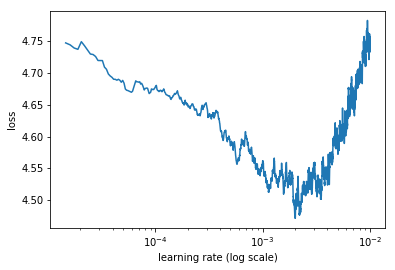

In [81]:
learner.sched.plot()

In [25]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      4.298781   4.102992   0.290868  
    1      4.160159   4.027761   0.29894                        



[array([4.02776]), 0.2989403556152848]

#### Classifier Model

In [29]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=chunksize)

In [33]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
0
1


In [34]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [35]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [36]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))

In [42]:
collections.defaultdict(lambda:0,{j:l for j,l in enumerate(itos[0:3])})

defaultdict(<function __main__.<lambda>>, {0: '_unk_', 1: '_pad_', 2: 'the'})

In [43]:
stoi=collections.defaultdict(lambda:0,{v:k for k,v in enumerate(itos)})

In [44]:
len(itos)

60002

In [45]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [46]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

In [47]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [48]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [49]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [50]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [59]:
??SortishSampler

#### Implement Sortish Sampler

In [55]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [60]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [61]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [62]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [63]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [64]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [65]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [66]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [68]:
wd = 1e-7
wd = 0
learner.save('lm1')
learner.save_encoder('lm1_enc')
learn.load_encoder('lm1_enc')

In [69]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 817/1042 [07:34<02:05,  1.80it/s, loss=1.29] 

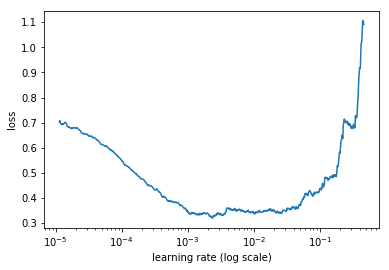

In [70]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [71]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  2%|▏         | 20/1042 [00:07<06:28,  2.63it/s, loss=0.47] 

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                      
    0      0.30602    0.227625   0.910181  



[array([0.22763]), 0.9101805475404818]

In [72]:
learn.save('clas_0')

In [73]:
learn.load('clas_0')

In [74]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.299519   0.220951   0.912745  



[array([0.22095]), 0.9127449239764279]

In [75]:
learn.save('clas_1')

In [76]:
learn.load('clas_1')

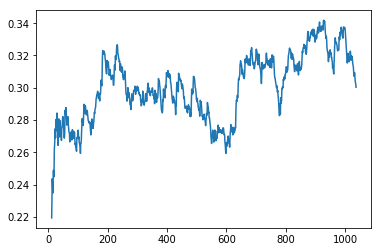

In [77]:
learn.sched.plot_loss()